# DS Interview Challenge


Author: Wanda Wang

# Part 1: SQL Syntax

```SQL
SELECT city_name, percentile_disc(0.90) 
      WITHIN GROUP (ORDER BY time_difference) 
      AS ninetieth_percentile
 FROM 
 (SELECT c2.city_name, (t1.actual_eta - t1.predicted_eta) AS time_difference
        FROM trips AS t1
        JOIN cities AS c2
        ON t1.city_id = c2.city_id
        WHERE t1.request_at > NOW() - INTERVAL '30 days'
        AND c2.city_name IN ('Qarth','Meereen')
        AND t1.status = 'completed'
     ) AS time_differences_city     
GROUP BY city_name;
```

output has city_name, ninetieth_percentile as columns

```SQL
SELECT c2.city_name, 
       temp1.day_of_the_week, 
       (100*sum(temp1.trip_completed)/count(*)) AS signup_percentage
FROM (SELECT e.city_id, EXTRACT(DOW from e._ts) AS day_of_the_week,
           CASE WHEN EXTRACT(EPOCH FROM e._ts-t.request_at)/3600 <=168 
           AND t.status = 'completed'
           THEN 1 
           ELSE 0 
           END AS trip_completed
      FROM events AS e
      JOIN trips AS t 
      ON e.rider_id = t.client_id
      WHERE e.event_name = 'sign_up_success'
      
      AND EXTRACT(WEEK FROM e._ts) = 1
      AND EXTRACT(YEAR FROM e._ts) = 2016
     )
      AS temp1
     
JOIN cities AS c2
ON temp1.city_id=c2.city_id
WHERE c2.city_name IN ('Qarth','Meereen')
GROUP BY  c2.city_name, temp1.day_of_the_week;
```

output has city_name, day_of_the_week, signup_percentage

# Part 2: Experiment & metrics design

1) Primary success metric: 
A) Driver retention - All of the new features aim to improve driver retention in some fashion. By providing drivers with a heat map of profitable hotspots and a personalized feed of upcoming activities/earnings opportunities, Uber helps drivers waste less time and gas, ultimately increasing their profit per hour. Greater visibility around earnings via a dedicated section allows drivers to more efficiently track and reach their take home pay targets.Finally, by providing more tailored ratings feedback to drivers, Uber can put drivers in a position to achieve better ratings in the future and better protect against the possibility of driver deactivation. Ultimately Uber's low prices for consumers are driven by a steady supply of Uber drivers on the road, and the redesigned Partner app provides a host of features that incentivizes drivers to stay with Uber. 

Additional tracking metrics:

B) Driver ratings, before and after the redesign to observe whether passenger satisfaction improved as a result of the more tailored ratings feedback. 

C) Uber traffic response to the recommended areas in the heat map. Number of pickups in recommended areas vs. non-recommended areas has a statistically significant increase or decrease.


2) Testing Plan

A) Driver Retention :

       Null Hypothesis: Percentage(%) of Driver Disconnects remain the same across various tenure buckets/cohorts (0-3 mos, 3-6mos,6mos-1yr) at [determine a baseline].

       Alternative Hypothesis: Percentage(%) of Driver Disconnects have changed, a statistically significant increase or decrease across various tenure buckets/cohorts (0-3 mos, 3-6mos,6mos-1yr)

B) Driver ratings:

    Null Hypothesis: Passenger ratings or satisfaction remains the same at at [determine a baseline].

    Alternative Hypothesis: Passenger ratings or satisfaction, will have a statistically significant increase or decrease.
    
C) Track Uber traffic response: 

    Null Hypothesis: Number of pickups in all areas remain the same at [determine a baseline].

    Alternative Hypothesis: Number of pickups in recommended areas vs. non-recommended areas has a statistically significant increase or decrease.

Perform Hypothesis or A/B testing (2 sample t test) which will help determine the probability that a experimental treatment (variation or the redesigned app) is better than the original version, while assuming the treatment will perform the same as the original. The goal is to disprove the Null Hypothesis.

Balancing Statistical Rigor with Risks - we have to make the following considerations:

Sample Size selection - Ensures that the experiment has adequate data for statistically significant result, if there is one to be found. The larger the sample size, the more sure we can be in the result of the experiment (assuming that it is a randomized sample). 
Random Sampling - Segment drivers in randomly selected geographies (e.g. urban, suburban, rural, East Coast, West Coast etc.) Randomly assign 50% of the sample population to be upgraded to the new app, 50% to stay frozen in the older version. If it is not random, it can introduce errors due differences in behavior of the sampled population. 

Effect and the baseline rate also have a negative relationship with sample size. 

1) Baseline metric: For Driver Retention, could be historical average of driver disconnect %'s across the various tenure buckets/cohorts (0-3 mos, 3-6mos,6mos-1yr) we plan on testing, across all seasons. 

2) Effect: Also make a best guestimate of the Minimum Detectable Effect, (e.g. expected lift) we want to see from our test. Determine the amount of difference between the original and variant of a test. If there is a small effect size (say a 0.1% increase in conversion rate) we may need a very large sample size or longer experiment to determine whether that difference is significant or just due to chance. 

Our Constraints also include the available time to run the experiment.

Fixed Horizon - If we're under a time crunch, we can adjust the sample size to be larger for a greater test population. We can also prioritize tests in terms of expected impact and difficulty of implementation.

Significance level - also affects sample size, but we should not set significance below 95% (the widely accepted standard for statistical significance) unless we have a higher tolerance for statistical error. However, per scenario, threshold can vary it is possible to take action on our results at either a higher or lower level of statistical significance.

Potential Risks: 

False discoveries - from testing lots of goals and variations at once.
Even if an experiment variation reaches 95% statistical significance, there is a 1/20 chance that the effect was found due to random chance, and not because of the redesign.
If there are four variations and four goals, that’s 16 potential
outcomes that need to be controlled for separately. 

To mitigate risks, validate that our testing software has no bugs which can miscount or skew results, do some QA across browsers/devices before going live. Observe any seasonal effects on driver behavior or find a testing period (spring break, holidays, weekends) and use a period where seasonal effects according to business domain knowledge is less or behavior is more consistent. Also with multplie tests, we may not be able to measure or track driver behavior of any potential downstream effects. Make sure to not change anything mid-experiement such as sample size allocation.

3) Before performing the test a threshold value is chosen, called the significance level of the test, traditionally 5% or 1% and denoted as α. A p-value helps us determine the significance of your results. If the p-value is equal to or smaller than the significance level (α), it suggests that the observed data are inconsistent with the assumption that the null hypothesis is true, and thus that hypothesis must be rejected and the alternative hypothesis is accepted as true. 

Expected experiment ROI- Higher ROI leads to increased management expectations. If we can, run the experiments longer to achieve higher levels of statistical significance. If we're focused instead concept validation, we can adjust our threshold - management may be willing to accept a higher level of statistical error for the sake of moving
quickly and validating or disproving a hypothesis

Evaluation of Results: If the redesign performs better even one metric ( p value <0.05), while other metrics are unaffected, I recommend proceeding with the launch. Otherwise if it's performing worse, I recommend not going ahead with the launch. Further analysis may be required if we have varying directional results between the three metrics. 


# Part 3: Data Analysis

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from __future__ import division
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
%matplotlib inline
os.chdir('/Users/wandawang/Desktop')

Loading in Data

In [2]:
data = pd.read_excel('ds_challenge_v2_1_data.xlsx', header = 0)
data.head(2)

,id,city_name,signup_os,signup_channel,signup_date,bgc_date,vehicle_added_date,vehicle_make,vehicle_model,vehicle_year,first_completed_date
0,1,Strark,ios web,Paid,2016-01-02,NaT,NaN,NaN,NaN,NaN,NaN
1,2,Strark,windows,Paid,2016-01-21,NaT,NaN,NaN,NaN,NaN,NaN


Review Dimensions and Data Types

In [3]:
data.shape #(54681, 11)
data.dtypes  #datetime64[ns]

for cat in ['city_name', 'signup_os', 'signup_channel',\
     'vehicle_make', 'vehicle_model','vehicle_year']:
    print("Number of levels in category '{0}': \b {1:2.2f} ".format\
          (cat, data[cat].unique().size))

Number of levels in category 'city_name':  3.00 
Number of levels in category 'signup_os':  6.00 
Number of levels in category 'signup_channel':  3.00 
Number of levels in category 'vehicle_make':  47.00 
Number of levels in category 'vehicle_model':  369.00 
Number of levels in category 'vehicle_year':  25.00 


Categorical variables: city_name, signup_os, signup_channel,vehicle_make,vehicle_model

Dates variables: signup_date, vehicle_added_date, first_completed_date

Note that for Levels: vehicle_model has a whopping 369 levels

Missingness: What fraction of the data is missing?
Are there any relationships between variables for missingness?

In [168]:
print data.isnull().sum()/len(data.index)
print data.dtypes

id                      0.000000
city_name               0.000000
signup_os               0.125400
signup_channel          0.000000
signup_date             0.000000
bgc_date                0.398402
vehicle_added_date      0.759807
vehicle_make            0.758179
vehicle_model           0.758179
vehicle_year            0.758179
first_completed_date    0.887767
dtype: float64
id                               int64
city_name                       object
signup_os                       object
signup_channel                  object
signup_date             datetime64[ns]
bgc_date                datetime64[ns]
vehicle_added_date              object
vehicle_make                    object
vehicle_model                   object
vehicle_year                   float64
first_completed_date            object
dtype: object


88% missing for the response variable of first_completed_date. 76% missing for vehicle_added_date, 39.8% missing for bgc_date. 

Make, Model, Year have the same amount of missingness of 75.8%. 


Data Visualizations:

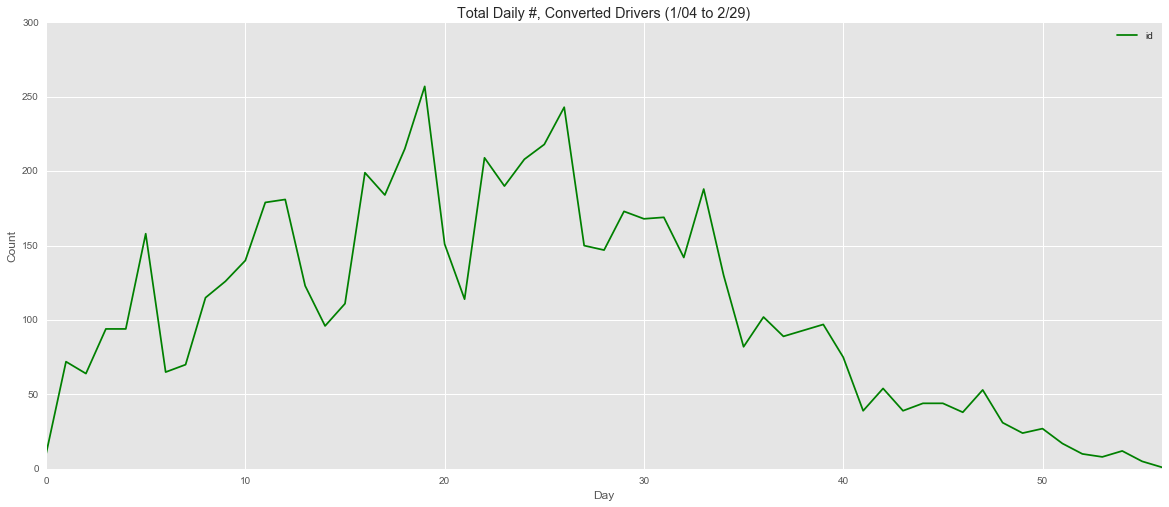

In [65]:
#How many signedup drivers completed a first trip daily? Count looks like it falls after 30 day mark. 
data.groupby('first_completed_date')['id'].count() 
dcd = data.groupby('first_completed_date')['id'].count().reset_index()
plt.figure()
with pd.plot_params.use('x_compat', True):
    dcd.plot(color='g', figsize=(20,8)).set_title('Total Daily #, Converted Drivers (1/04 to 2/29)')
plt.xlabel('Day')
plt.ylabel('Count')

Attribution by browser, city_name, signup_os, signup_channel

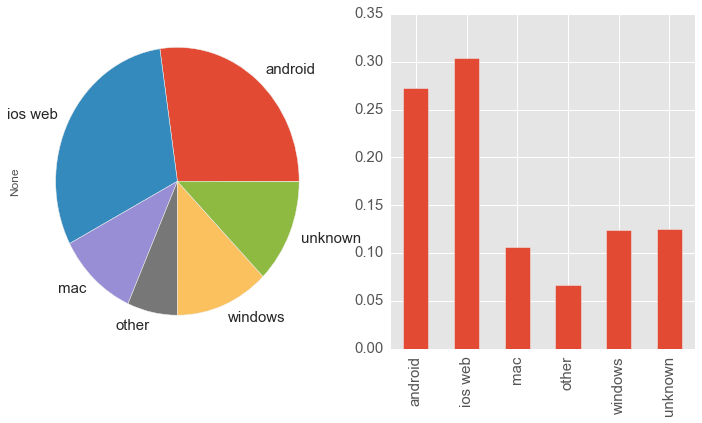

In [69]:
browser = {'android': 0.273, 'ios web': 0.304, 'mac': 0.1065, 'other': 0.0667, 'windows': 0.1239, 'unknown':.1254}
browser = pd.Series(browser, index = ['android', 'ios web', 'mac', 'other', 'windows', 'unknown'])
plt.rcParams['figure.figsize'] = 12, 6
plt.subplot(121)
browser.plot(kind='pie', fontsize=15)
plt.subplot(122)
browser.plot(kind='bar', fontsize=15)

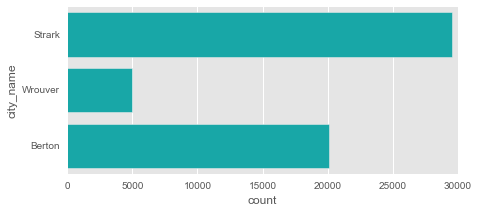

In [82]:
f, ax = plt.subplots(figsize=(7, 3))
sns.countplot(y="city_name", data=data, color="c");

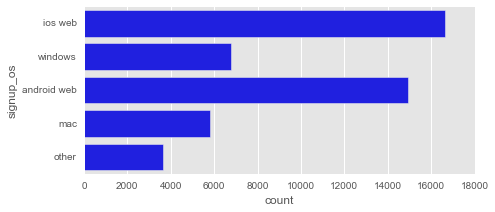

In [75]:
f, ax = plt.subplots(figsize=(7, 3))
sns.countplot(y="signup_os", data=data, color="b");

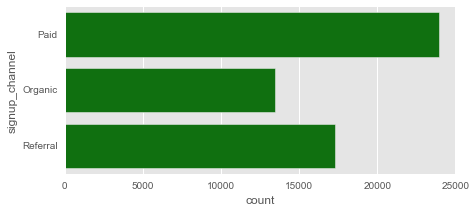

In [77]:
f, ax = plt.subplots(figsize=(7, 3))
sns.countplot(y="signup_channel", data=data, color="g");

# 1. Data Cleaning
1) Convert categorical variables into numerical. 

2) Replace missing values with "Unknown[variableColumnName]" to count presence of missing values (NaN == 1).

3) Date variables "signup_date, first_completed_date"

Assumption: If date value exists, event occurred as '1'. If NaN, even has not occurred as '0'. 

3) Date variables "bgc_date, vehicle_added_date"

Count missing dates, (NaN == 1).

4) Replace vehicle year missing values with 0. 

5) Create target variable  for first_completed_date which is what 
we will predict.

In [4]:
cities = pd.get_dummies(data.city_name)
os = pd.get_dummies(data.signup_os.fillna('UnknownOS'))
channel = pd.get_dummies(data.signup_channel)
vehicle_make = pd.get_dummies(data.vehicle_make.fillna('UnknownMake'))
vehicle_model = pd.get_dummies(data.vehicle_model.fillna('UnknownModel'))# too many levels 

bgc = [pd.notnull(i)*1 for i in data.bgc_date] #should drop later
vehicle_added = [pd.notnull(i)*1 for i in data.vehicle_added_date] #should drop later

vehicle_year = [int(i) for i in data.vehicle_year.fillna(0)] #replace nulls with 0

bgc_null = [pd.isnull(i)*1 for i in data.bgc_date]
vad_null = [pd.isnull(i)*1 for i in data.vehicle_added_date]

data['vehicle_added_date'] = pd.to_datetime(data['vehicle_added_date'])
data['first_completed_date'] = pd.to_datetime(data['first_completed_date'])

Response Variable

Assumption: If 'first_completed_date' date value exists, event occurred as '1'. If NaN, even has not occurred as '0'. 

In [5]:
has_converted = [pd.notnull(i)*1 for i in data.first_completed_date] #target response

sub_data = pd.DataFrame({'bgc':bgc,'vehicle_added':vehicle_added,'vehicle_year':vehicle_year})

event_nullcounts = pd.DataFrame({'bgc_null':bgc_null,'vad_null':vad_null,'has_converted':has_converted})

clean_data=pd.concat([cities,os,channel,vehicle_make,sub_data,event_nullcounts],axis=1)


# 1. What fraction of the driver signups took a first trip?

In [6]:
fraction = float(len(clean_data[clean_data.has_converted == 1]))/float(len(clean_data))*100.0
print "Fraction of the driver signups took a first trip: {:.2f}%".format(fraction)

Fraction of the driver signups took a first trip: 11.22%


Data Visualizations:

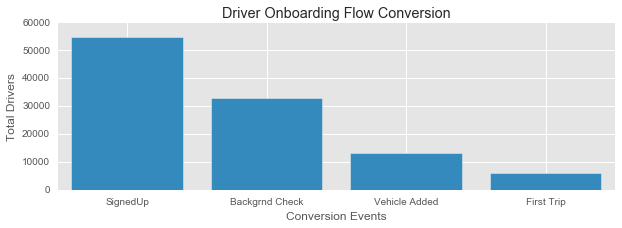

In [7]:
fig = plt.figure(figsize=(10, 3))
events = ('SignedUp', 'Backgrnd Check', 'Vehicle Added', 'First Trip')
y_p = np.arange(len(events))
funnel = [len(data['signup_date']), sum(bgc), sum(vehicle_added), sum(has_converted)] 
plt.bar(y_p, funnel, align='center', alpha=1)
plt.xticks(y_p, events)
plt.xlabel('Conversion Events')
plt.ylabel('Total Drivers')
plt.title('Driver Onboarding Flow Conversion')

Questions: What % of driver signups have a bgc_date? 
What % of driver signups have a vehicle_added_date?

In [8]:
bgcfraction = float(len(clean_data[clean_data.bgc  == 1]))/float(len(clean_data))*100.0
print "Percentage of the driver signups completed bgc: {:.2f}%".format(bgcfraction)
vfraction = float(len(clean_data[clean_data.vehicle_added  == 1]))/float(len(clean_data))*100.0
print "Percentage of the driver signups completed vad: {:.2f}%".format(vfraction)

Percentage of the driver signups completed bgc: 60.16%
Percentage of the driver signups completed vad: 24.02%


Question: Are the events sequential? For example, does a driver have to complete a background check or vehicle add prior to First Trip? Does a driver have to complete a background check before vehicle add? 

Answer: No, see below:

In [9]:
print event_nullcounts.groupby('has_converted').sum()

               bgc_null  vad_null
has_converted                    
0                 21785     41282
1                     0       265


(0, 42000)

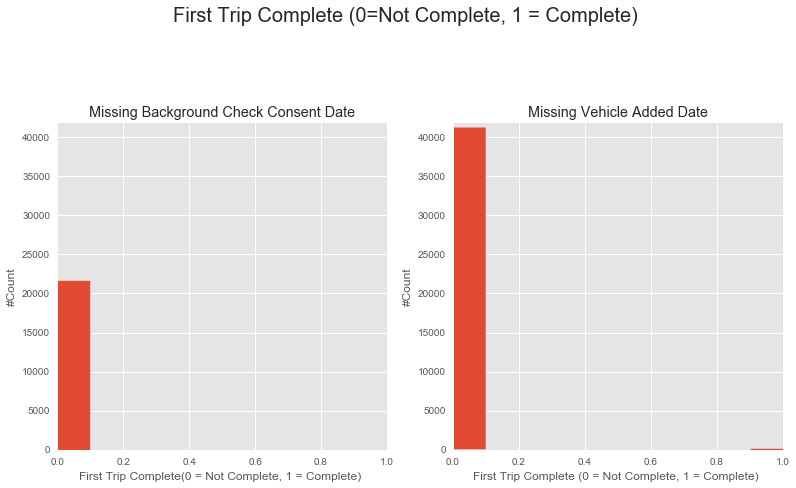

In [86]:
fig = plt.figure(figsize=(13, 20))
fig.suptitle("First Trip Complete (0=Not Complete, 1 = Complete) ", fontsize=20)
ax1 = plt.subplot("321")
ax1.set_title("Missing Background Check Consent Date")
ax1.hist(event_nullcounts['has_converted'][event_nullcounts.bgc_null==1]) #21,785
ax1.set_ylabel('#Count') 
ax1.set_xlabel('First Trip Complete(0 = Not Complete, 1 = Complete) ')
ax1.set_xlim(0,1)
ax1.set_ylim(0,42000)

ax2 = plt.subplot("322")
ax2.set_title("Missing Vehicle Added Date")
ax2.hist(event_nullcounts['has_converted'][event_nullcounts.vad_null==1]) #41,547
ax2.set_ylabel('#Count') #
ax2.set_xlabel('First Trip Complete (0 = Not Complete, 1 = Complete) ')
ax2.set_xlim(0,1)
ax2.set_ylim(0,42000)

Out of the total of 54,681 drivers:

Over 21.7K who did not complete a first trip (0 = Not Complete) were missing a bgc date. All converted drivers had a bgc date(there is no vertical bar at 1 = Complete). 

Only 265 missing their VAD date converted, completing a first trip (1 = Complete). Most drivers (Over 41K)missing a VAD did not complete a first trip (0 = Not complete). Over half, or 21.5K of these non converted drivers also did not have a bgc date. The rest of the converted drivers, 5,872(the 11.22% from signup), had both a VAD date and BGC date. A total of 6137 drivers converted fully from signup.  

Thus new features counting VAD and BGC nulls should be included in the dataset along with measuring the days difference between signup and bgc, and days difference between signup and vad. Time can be an interesting metric to analyze. 


3) Feature Engineering/Selection: 
New Features for

+Null counts for Background Check Consent Date, and Vehicle Added Date

+Time difference in days between signup_date and bgc_date

+Time difference in days between signup_date and vehicle_added_date

+Vehicle Class


In [11]:
def bgc_diff(row):
    if pd.isnull(row['bgc_date']) == False :
        return float((row['bgc_date'] - row['signup_date']).days)
    else:
        pass
    
def vad_diff(row):
    if pd.isnull(row['vehicle_added_date']) == False :
        return float((row['vehicle_added_date'] - row['signup_date']).days)
    else:
        pass 

def complete_diff(row):
    if pd.isnull(row['first_completed_date']) == False : #for all has driven
        return float((row['first_completed_date'] - row['signup_date']).days)
    else:
        pass

clean_data['bgc_diff'] = data.apply(lambda row: bgc_diff(row),axis=1)
clean_data['vad_diff'] = data.apply(lambda row: vad_diff(row),axis=1)

#Note: A small percentage or 220 values, data[clean_data['vad_bgc_diff']<0] #220
#differences between VAD and BGC include negative days as a result of either 
#vad < bgc or vad_diff < bgc_diff. vad_bgc_diff == 0, when vad and bgc on same day #2505

clean_data['vad_bgc_diff'] = clean_data['vad_diff'] - clean_data['bgc_diff']
clean_data['complete_diff'] = data.apply(lambda row: complete_diff(row),axis=1)

In [12]:
#mean imputation for NA values for bgc_diff and vad_diff

for column in clean_data:
    if column in ('bgc_diff', 'vad_diff','vad_bgc_diff'):
        mean_value = int(float(clean_data[column].mean(skipna=True, axis=0)))
        clean_data[column].fillna(mean_value, inplace=True)

In [13]:
clean_t_data = clean_data
clean_t_data['complete_diff'] = data.apply(lambda row: complete_diff(row),axis=1)

Visualize the data

(0, 0.3)

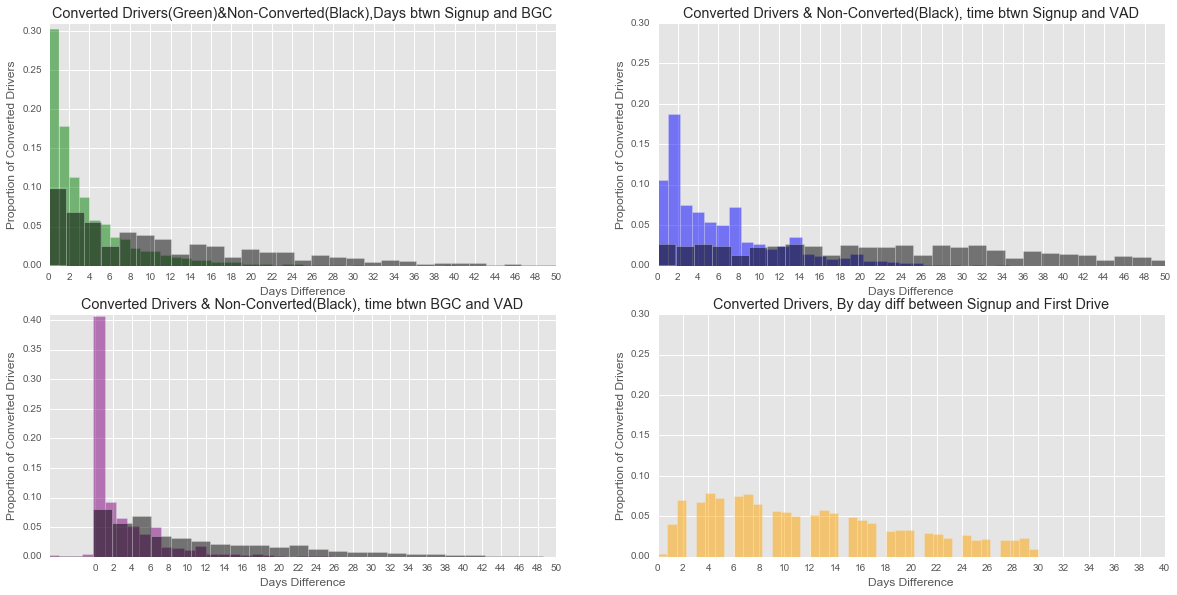

In [89]:
fig = plt.figure(figsize=(20, 20))
ax1 = plt.subplot("425")
ax1.set_title("Converted Drivers(Green)&Non-Converted(Black),Days btwn Signup and BGC")
num_bins = 40      #select bgc_diff column where bgc is not null and has converted
n, bins, patches = ax1.hist(clean_data['bgc_diff'][(clean_data.bgc_null==0) 
   & (event_nullcounts.has_converted==1)], num_bins, normed=1, facecolor='green', alpha=0.5)
n, bins, patches = ax1.hist(clean_data['bgc_diff'][(clean_data.bgc_null==0) 
   & (event_nullcounts.has_converted==0)], num_bins, normed=1, facecolor='black', alpha=0.5)
ax1.set_ylim(0,.31)
ax1.set_ylabel('Proportion of Converted Drivers')
x = range(0,52,2)
ax1.set_xticks(x)
ax1.set_xlim(0,50)
ax1.set_xlabel('Days Difference')
ax2 = plt.subplot("426")
ax2.set_title("Converted Drivers & Non-Converted(Black), time btwn Signup and VAD")
#bgc_null could be 1, 0
n, bins, patches = ax2.hist(clean_data['vad_diff'][(clean_data.vad_null==0) 
    & (event_nullcounts.has_converted==1)], num_bins, normed=1, facecolor='blue', alpha=0.5)
n, bins, patches = ax2.hist(clean_data['vad_diff'][(clean_data.vad_null==0) 
    & (event_nullcounts.has_converted==0)], num_bins, normed=1, facecolor='black', alpha=0.5)
ax2.set_ylabel('Proportion of Converted Drivers')
ax2.set_xticks(x)
ax2.set_xlim(0,50)
ax2.set_xlabel('Days Difference')
ax2.set_ylim(0,.3)
###################
ax3 = plt.subplot("427")
ax3.set_title("Converted Drivers & Non-Converted(Black), time btwn BGC and VAD")
n, bins, patches = ax3.hist(clean_data['vad_bgc_diff'][(clean_data.bgc_null==0) & (clean_data.vad_null==0) 
    & (event_nullcounts.has_converted==1)], num_bins, normed=1, facecolor='purple', alpha=0.5)
n, bins, patches = ax3.hist(clean_data['vad_bgc_diff'][(clean_data.bgc_null==0) & (clean_data.vad_null==0) 
    & (event_nullcounts.has_converted==0)], num_bins, normed=1, facecolor='black', alpha=0.5)
ax3.set_ylabel('Proportion of Converted Drivers')
ax3.set_xticks(x)
ax3.set_xlim(-5,50)
ax3.set_xlabel('Days Difference')
ax3.set_ylim(0,.41)
ax4 = plt.subplot("428")
ax4.set_title("Converted Drivers, By day diff between Signup and First Drive")
n, bins, patches = ax4.hist(clean_t_data['complete_diff'][(clean_data.bgc_null==0) & (clean_data.vad_null==0) 
     & (event_nullcounts.has_converted==1)], num_bins, normed=1, facecolor='orange', alpha=0.5)
ax4.set_ylabel('Proportion of Converted Drivers')
ax4.set_xticks(x)
ax4.set_xlim(0,40)
ax4.set_xlabel('Days Difference')
ax4.set_ylim(0,.3)

Looking at converted drivers who successfully made a first trip,
most of them took less than 10 days to give consent to a background check, 
after signing up. Non-conversions are taking more days before BGC.

Looking at the drivers who successfully made a first trip, most of them took less than 
20 days to add their vehicle, after signing up. Again non-conversions are taking more time, from signup to vad. 

The days difference between bgc and vad of converted drivers is mostly before 10 days as well. The days difference between signup and first drive is more varied from 0 to 30 days. We will use only the days difference from signup to BGC, and signup to vad as new features. 

New Feature: Vehicle_Class web-scraped from http://driveubernyc.com/vehiclelist. Please refer to vehiclelist.py script attachment. 

In [15]:
#Load in web-scraped data - Vehicle Model, Vehicle Class information
claz = pd.read_csv('class.csv', header = 0).iloc[:,0] 
model = pd.read_csv('model.csv', header = 0).iloc[:,0] 

In [16]:
#Create temporary table with web-scraped data
df_temp = pd.DataFrame({'vehicle_class':claz.values, 'car_model':model.\
                        values}).drop_duplicates(subset=['car_model']) #remove duplicates
df_temporary = pd.DataFrame(np.array([['UnknownModel', 'UnknownClass']]), \
        columns=['car_model', 'vehicle_class']).append(df_temp, ignore_index=True)
data_temp = pd.DataFrame({'vehicle_model':data['vehicle_model']})
data_temporary = pd.DataFrame(data_temp.vehicle_model.fillna('UnknownModel')) 
#Join vehicle_model on car_model
temp = data_temporary.merge(df_temporary,how='left',left_on='vehicle_model',right_on='car_model')
vehicle_class = temp.iloc[:,2:3] #Add vehicle_class onto dataset. 

In [17]:
#dummify vehicle_class
vehicle_class = pd.get_dummies(vehicle_class).fillna('UnknownClass')

In [18]:
#adding in vehicle class
data_new = pd.concat([clean_data, vehicle_class], axis=1)
data_new.head(3)

,Berton,Strark,Wrouver,UnknownOS,android web,ios web,mac,other,windows,Organic,...,vad_bgc_diff,complete_diff,vehicle_class_Not Accepted,vehicle_class_UberBLACK,vehicle_class_UberSUV,vehicle_class_UnknownClass,vehicle_class_uberBLACK,vehicle_class_uberX,vehicle_class_uberX (Sedan only),vehicle_class_uberXL
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,7.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,7.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,7.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Cleaned Dataset with New Features

Scale event diff variables from 0 to 1 ?

# 2. Predictive Modeling

 Build a predictive model to help Uber determine whether or not a driver signup will start driving. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance. (2 points)


In [21]:
target = data_new['has_converted']
data_new.drop(['has_converted', 'bgc', 'vehicle_added','vad_bgc_diff','complete_diff'],
    axis=1, inplace=True)

In [193]:
list(data_new.columns.values)
data_new.shape #72 columns

(54681, 72)

Model Choice - Random Forest Pros: Non-parametric, so we don't have to worry about outliers or whether the data is linearly separable. Does not suffer multicollinearity. OOB process reduces overfitting. Random forests tend to beat out logistic regression in terms of accuracy which we can test.

Split the data set into 2 parts: training set, test set(random_state=0, and test_size=1/3).

In [22]:
from sklearn.cross_validation import train_test_split
has_driven = pd.Series(target)
X_train, X_test, Y_train, Y_test = train_test_split(data_new,\
                                        has_driven,test_size=0.33,random_state=0)
print 'Train data set ratio: ', sum(Y_train)/float(X_train['vad_diff'].count())
print 'Test data set ratio:  ', sum(Y_test)/float(X_test['vad_diff'].count())

Train data set ratio:  0.111911780762
Test data set ratio:   0.112884455528


Random Forest.
Fit a random forest on the training set. Report the training error and test error.
Use the function grid_search.GridSearchCV to find the best parameters. What's the best parameters? What's the best score? What's the training error and test error of the best model. The possible combination of the parameters may be:

In [50]:
from sklearn import ensemble
randomForest = ensemble.RandomForestClassifier(n_jobs = -1, oob_score=True) #adding oob
import sklearn.grid_search as gs 

In [61]:
grid_para_forest = [{"n_estimators": range(10, 110, 10), "criterion": ["gini", "entropy"], 
                     'max_depth': range(1, 20), "min_samples_leaf": range(1, 5)}]

#n_estimators default is 10
#max_depth make this 20, default is none
#n_estimators, make this 10
#min_samples_leaf default is 1
#max_features keep auto

grid_search_forest = gs.GridSearchCV(randomForest, grid_para_forest, \
          cv=5, scoring='accuracy').fit(X_train, Y_train)
#5 fold cross validation used
print 'The best score is %.4f' %grid_search_forest.best_score_
print 'The best parameters are %s' %grid_search_forest.best_params_
print 'The training error is %.4f' %(1 - grid_search_forest.best_estimator_.score(X_train, Y_train))
print 'The testing error is %.4f' %(1 - grid_search_forest.best_estimator_.score(X_test, Y_test))

The best score is 0.9427
The best parameters are {'n_estimators': 90, 'criterion': 'gini', 'max_depth': 11, 'min_samples_leaf': 3}
The training error is 0.0531
The testing error is 0.0546


Results:
The best score is 0.9432
The best parameters are {'n_estimators': 90, 'criterion': 'gini', 'max_depth': 11, 'min_samples_leaf': 3}
The training error is 0.0529
The testing error is 0.055.

The errors are quite low.

In [94]:
forest_final = grid_search_forest.best_estimator_
feature_imprtance = zip(data_new.columns[1:], forest_final.feature_importances_)
dtype = [('feature', 'S10'), ('importance', 'float')]
feature_imprtance = np.array(feature_imprtance, dtype = dtype)
feature_sort = np.sort(feature_imprtance, order='importance')[::-1]
feature_sort[0:15]

array([('vehicle_cl', 0.304685994127146),
       ('bgc_diff', 0.12318402650513946),
       ('Volkswagen', 0.11978195633333964),
       ('vad_diff', 0.11611855072049951),
       ('bgc_null', 0.11155295736634972),
       ('vehicle_cl', 0.10168900474058443),
       ('vehicle_cl', 0.03033172575359743),
       ('vad_null', 0.01777606230852388),
       ('UnknownMak', 0.01233348884726729), ('Acura', 0.01161262295068003),
       ('Hummer', 0.004792889465302463),
       ('Referral', 0.004352437656548156),
       ('android we', 0.004261551357312728),
       ('vehicle_cl', 0.0035475358509529185),
       ('Oldsmobile', 0.002940883513185913)], 
      dtype=[('feature', 'S10'), ('importance', '<f8')])

Feature Importance Plot

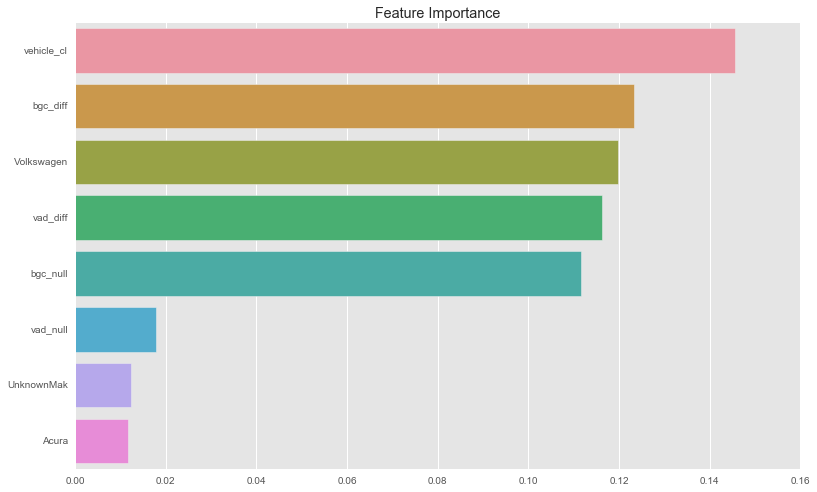

In [91]:
feature_sort_columns = [i for (i, j) in feature_sort[0:10]] 
plt.figure(figsize=(13, 8))
plt.title("Feature Importance")
importances = [j for (i, j) in feature_sort[0:10]] 
sns.barplot(y=feature_sort_columns, x=importances, ci=None)

The model suggests that Vehicle Class, BGC Days Difference from Signup, Vehicle Model, VAD Days Difference from Signup, BGC_Nulls, are the top 5 features to predict first drive completion.

Model Theory Discussion

Although both random forest and gradient boosting are ensemblers, random forest 
decorrelates decision trees, improving upon bagging, building various decision trees on bootstrapped training samples, but splitting internal nodes in a special way. 

Each time a split is considered within the construction of a decision tree, only a random subset of m of the overall p predictors are allowed to be candidates. At every split, a new subset of predictors is randomly selected.The random forest procedure forces the decision tree building process to use different predictors to split at different times. Should a good predictor be left out of consideration for some splits, it still has many chances to be considered in the construction of other splits. We can’t overfit by adding more trees! At each iteration, the classifier is being trained independently. 

For GBM, the boosting procedure works in a similar way, except that the decision trees are generated in a sequential manner: Each tree is generated using information from previously grown trees; the addition of a new tree improves upon the performance of the previous trees.The trees are now dependent upon one another. Gradient Boosting builds on weak classifiers, adding one at a time so that the next one is trained to improve the already trained ensemble. 

In [ ]:
Gradient Boosting

In [109]:
from sklearn.ensemble import GradientBoostingClassifier
gbm = GradientBoostingClassifier(max_features=10, n_estimators=500, 
                                 learning_rate=0.05, random_state= 2015)
gbm.fit(X_train, Y_train)

GradientBoostingClassifier(init=None, learning_rate=0.05, loss='deviance',
              max_depth=3, max_features=10, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=2015, subsample=1.0, verbose=0,
              warm_start=False)

In [115]:
import sklearn.metrics
print sklearn.metrics.roc_auc_score(Y_train, gbm.predict_proba(X_train)[:,1])
print sklearn.metrics.roc_auc_score(Y_test, gbm.predict_proba(X_test)[:,1])

0.974554853311
0.97160652001


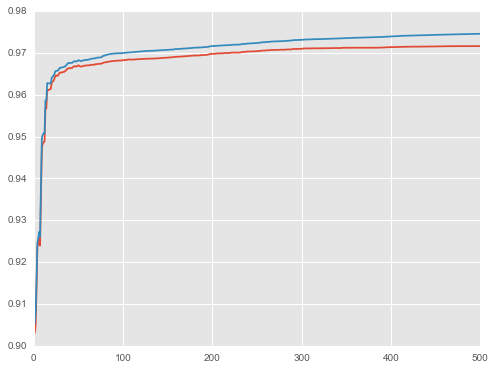

In [124]:
def plot_gbt_learning(gbt):
    test_score = np.empty(len(gbt.estimators_))
    train_score = np.empty(len(gbt.estimators_))
    for i, pred in enumerate(gbt.staged_predict_proba(X_test)):
         test_score[i] = sklearn.metrics.roc_auc_score(Y_test, pred[:,1])
    for i, pred in enumerate(gbt.staged_predict_proba(X_train)):
         train_score[i] = sklearn.metrics.roc_auc_score(Y_train, pred[:,1])
    plt.figure(figsize=(8,6))
    plt.plot(np.arange(gbt.n_estimators) + 1, test_score, label='Test') 
    plt.plot(np.arange(gbt.n_estimators) + 1, train_score, label='Train')
plot_gbt_learning(gbm)

The above plot shows that an AUC score of 0.97 is reached withi 100 estimators for both training(red) and test sets(blue).

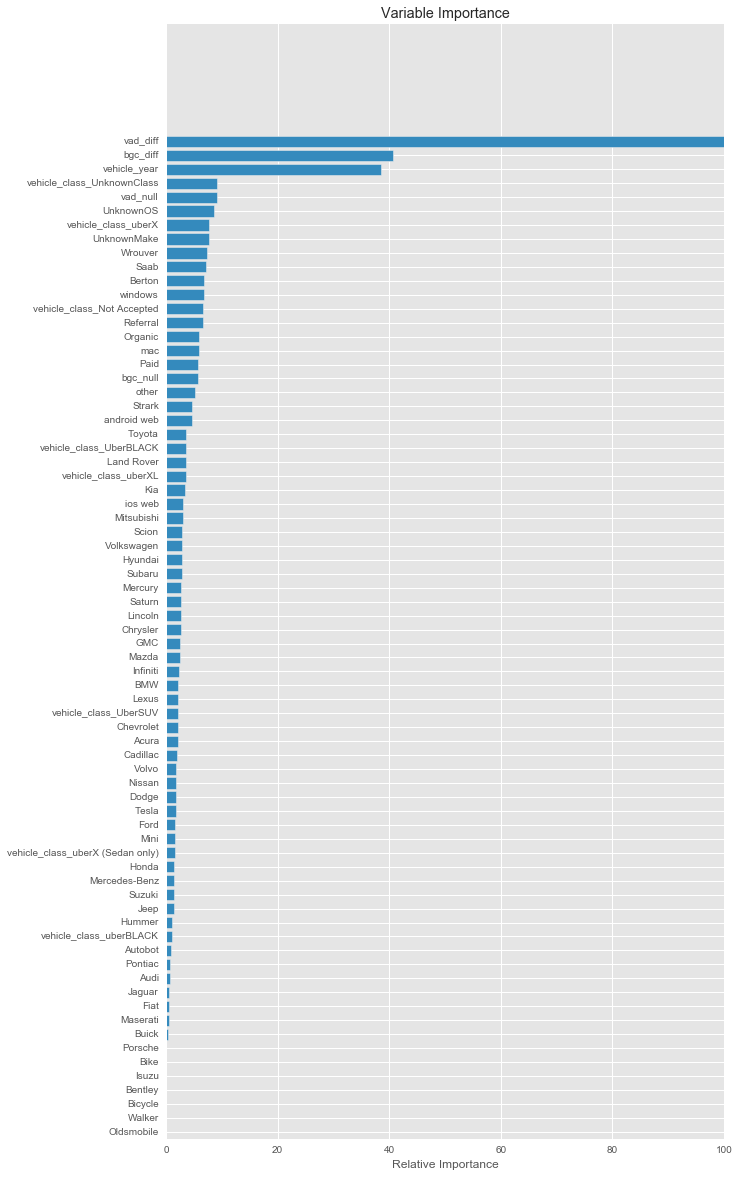

In [205]:
feature_importance = gbm.feature_importances_ 
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10, 20))
#plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[[sorted_idx]])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

Vad_diff, bgc_diff,  are the top 2 features from the GBM model

Uber can generate more first trips by focusing on speeding up time taken between Signup, giving background check consent, and vehicle add.

Uber could increase marketing efforts to drivers - targeted emails, calls, educational material-in effort to reduce this timeframe, which may lead to first drives being completed or even conversion later on. 
